In [3]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME

RSEED = 42
# Modeling Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')


## Objectives of this notebook
- Implement feature importance by using SHAP approach 
- Using the results of our random forest model 
- Data that are used: cleaned data of second iteration (including all missing values)

In [4]:
df = pd.read_csv('/Users/julianeberek/neuefische/TheFluShot/data/Flu_Shot_Data_cleaned_2.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   26707 non-null  int64  
 1   h1n1_vaccine                 26707 non-null  int64  
 2   seasonal_vaccine             26707 non-null  int64  
 3   h1n1_concern                 26615 non-null  float64
 4   h1n1_knowledge               26591 non-null  float64
 5   behavioral_antiviral_meds    26636 non-null  float64
 6   behavioral_avoidance         26499 non-null  float64
 7   behavioral_face_mask         26688 non-null  float64
 8   behavioral_wash_hands        26665 non-null  float64
 9   behavioral_large_gatherings  26620 non-null  float64
 10  behavioral_outside_home      26625 non-null  float64
 11  behavioral_touch_face        26579 non-null  float64
 12  doctor_recc_h1n1             24547 non-null  float64
 13  doctor_recc_seas

In [6]:
df.head()

,Unnamed: 0,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,0,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,0,0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [7]:
# Column 'unnamed: 0' is another index and we will drop it 
df = df.drop('Unnamed: 0', axis=1)

## Setting up the model
- Preparing data 
- Encoding the categorical variables 
- Instatiating the Random Forest model 
- when using sklearn preprocessing SHAP implementation needs to be adapted

### First trial: H1N1 as target variable and seasonal flu not included in features

In [8]:
# Creating target variable y for h1n1 vaccine and saving it to an array 

y = df[['h1n1_vaccine']].copy()
y = y.to_numpy()

In [9]:
# saving the features into variable X, dropping the two target variables

X = df.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

In [10]:
# Preparing the categorical variables for the pipeline
cat_features_new = list(df.columns)

In [11]:
# seasonal vaccine will not be included into the features 

cat_features_new.remove('seasonal_vaccine')

In [12]:
cat_features_new.remove('h1n1_vaccine')

In [13]:
rf_model = RandomForestClassifier(n_estimators=100)

In [14]:
# Mulitoutput Classifier gave an issue with SHAP so I changed it simply to Random Forest CLF
'''estimators_rf= MultiOutputClassifier(
    estimator=rf_model
)'''

'estimators_rf= MultiOutputClassifier(\n    estimator=rf_model\n)'

In [15]:
estimators_rf = rf_model

In [16]:
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [17]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features_new)
])

In [18]:
full_pipeline_rand_forst= Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators_rf),
])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=RSEED)

In [20]:
full_pipeline_rand_forst.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor

In [21]:
rf_train_pred = full_pipeline_rand_forst.predict(X_train)
rf_test_pred = full_pipeline_rand_forst.predict(X_test)

In [22]:
# Evaluating model performance

In [23]:
print("Accuracy: {:.2f}".format(accuracy_score(y_test, rf_test_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, rf_test_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, rf_test_pred)))
print("F1: {:.2f}".format(f1_score(y_test, rf_test_pred)))
print("ROC: {:.2f}".format(roc_auc_score(y_test, rf_test_pred
                                        )))

Accuracy: 0.85
Recall: 0.44
Precision: 0.75
F1: 0.55
ROC: 0.70


## Implementing SHAP values

In [24]:
# Importing the package  
# Prior to that, we need to install shap in the venv: pip install shap 
# we need to add shap to our requirements  

import shap

In [25]:
# Setting up a preprocessor for transforming the X as we did in the modelling pipeline

preprocess_pipeline_rand_forst= Pipeline([
    ("preprocessor", preprocessor)
])

In [26]:
# Assigning one row of X for the transformation

#X_new = X_train[X_train.iloc[4]]
#X_new = X_train[X_train.index==10998]
X_new = X_train
X_new.sample(frac=0.01)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
9802,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,kbazzjca,Non-MSA,0.0,0.0,NaN,NaN
25886,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,oxchjgsf,Non-MSA,1.0,0.0,fcxhlnwr,oijqvulv
20926,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,fpwskwrf,Non-MSA,1.0,2.0,fcxhlnwr,cmhcxjea
17442,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
16234,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,kbazzjca,"MSA, Principle City",1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,oxchjgsf,Non-MSA,1.0,1.0,nduyfdeo,xtkaffoo
23175,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,Not Married,Own,Not in Labor Force,mlyzmhmf,"MSA, Not Principle City",0.0,0.0,NaN,NaN
24398,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Rent,Unemployed,lzgpxyit,"MSA, Not Principle City",1.0,1.0,NaN,NaN
26476,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,lzgpxyit,"MSA, Principle City",1.0,2.0,NaN,NaN


In [25]:
# do we need this? 
# preprocess_pipeline_rand_forst.fit(X_new)

In [27]:
preprocess_pipeline_rand_forst.transform(X_new)

<21365x148 sparse matrix of type '<class 'numpy.float64'>'
	with 443701 stored elements in Compressed Sparse Row format>

In [28]:
# The SHAP module needs to be adapted if we want to apply it to a pipeline
model = full_pipeline_rand_forst.named_steps['estimators']

explainer = shap.TreeExplainer(full_pipeline_rand_forst.named_steps['estimators'])

In [29]:
# This is running for hours ...
shap_values = explainer.shap_values(preprocess_pipeline_rand_forst.transform(X_new).toarray())

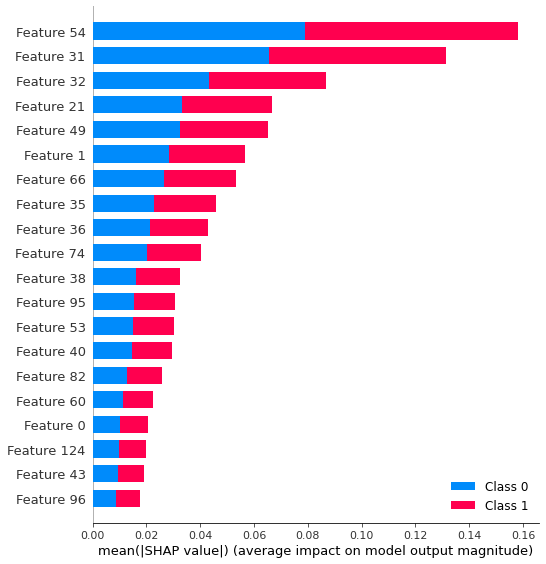

In [ ]:
shap.summary_plot(shap_values, plot_type="bar")

In [ ]:
column_name = preprocess_pipeline_rand_forst.named_steps['preprocessor'].get_feature_names(cat_features_new)
one_hot_encoded_frame =  pd.DataFrame(X_new.todense(), columns= column_name)

hot_encoder = preprocessor.named_transformers_["cat"]['1hot']
hot_encoder_names = hot_encoder.get_feature_names(cat_features)
column_names = num_features + list(hot_encoder_names) 

TypeError: get_feature_names() takes 1 positional argument but 2 were given

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_new.iloc[0,:])

Exception: Length of features is not equal to the length of shap_values!

In [ ]:
row_to_show = 5
data_for_prediction = X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


model.predict_proba(data_for_prediction_array)

ValueError: could not convert string to float: '65+ Years'

In [ ]:
model.predict(preprocess_pipeline_rand_forst.transform(X_new))

array([1])

In [ ]:
choosen_instance = X_test.loc[[5]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

KeyError: "None of [Int64Index([5], dtype='int64')] are in the [index]"